In [19]:
import json
import os

os.chdir('/home/censky2/MLDLFinal')
with open('./data/nuclei_annotations/01_training_dataset_geojson_nuclei/training_set_metastatic_roi_001_nuclei.geojson', 'r') as f:
    annotation_data = json.load(f)

print(annotation_data.keys())


dict_keys(['type', 'features'])


In [20]:
# Step 1: Explore the 'features' field which contains nuclei annotations.
features = annotation_data['features']
print("Number of nuclei (features) in this annotation file:", len(features))

Number of nuclei (features) in this annotation file: 633


In [21]:
# Step 2: Print the first feature to see its structure.
# Each feature typically represents a single nucleus.
from pprint import pprint
pprint(features[0])

{'geometry': {'coordinates': [[[894, 761],
                               [893, 762],
                               [891, 762],
                               [890, 763],
                               [886, 763],
                               [885, 764],
                               [884, 764],
                               [883, 765],
                               [882, 765],
                               [881, 766],
                               [880, 766],
                               [879, 767],
                               [878, 767],
                               [877, 768],
                               [876, 768],
                               [874, 770],
                               [873, 770],
                               [872, 771],
                               [871, 771],
                               [870, 772],
                               [869, 772],
                               [868, 773],
                               [867, 773],
           

In [22]:
# Step 3: Check the properties of the first nucleus
# Properties usually contain metadata, such as the class/type of the nucleus.
nucleus_properties = features[0].get('properties', {})
print("\nNucleus properties:")
pprint(nucleus_properties)


Nucleus properties:
{'classification': {'color': [200, 0, 0], 'name': 'nuclei_tumor'},
 'objectType': 'annotation'}


In [23]:
# Step 4: Check the geometry of the first nucleus.
# Geometry should contain polygon coordinates outlining the nucleus.
nucleus_geometry = features[0].get('geometry', {})
print("\nNucleus geometry:")
pprint(nucleus_geometry)


Nucleus geometry:
{'coordinates': [[[894, 761],
                  [893, 762],
                  [891, 762],
                  [890, 763],
                  [886, 763],
                  [885, 764],
                  [884, 764],
                  [883, 765],
                  [882, 765],
                  [881, 766],
                  [880, 766],
                  [879, 767],
                  [878, 767],
                  [877, 768],
                  [876, 768],
                  [874, 770],
                  [873, 770],
                  [872, 771],
                  [871, 771],
                  [870, 772],
                  [869, 772],
                  [868, 773],
                  [867, 773],
                  [862, 778],
                  [862, 779],
                  [860, 781],
                  [860, 782],
                  [859, 783],
                  [859, 784],
                  [858, 785],
                  [858, 786],
                  [857, 787],
                  [85

In [24]:
# Step 5: Identify the corresponding image.
# The geojson file name is something like 'training_set_metastatic_roi_001_nuclei.geojson'
# The corresponding image should be 'training_set_metastatic_roi_001.tif'
# extract the base name to find the image.
import glob

geojson_file = './data/nuclei_annotations/01_training_dataset_geojson_nuclei/training_set_metastatic_roi_001_nuclei.geojson'
base_name = os.path.basename(geojson_file).replace('_nuclei.geojson', '')
# look for a TIFF image with the same base name.
image_path = glob.glob(f"./data/ROIs/01_training_dataset_tif_ROIs/{base_name}.tif")

if len(image_path) == 1:
    print("\nMatching image found:", image_path[0])
else:
    print("\nNo direct matching image found. Check your file naming.")
    # may adjust the pattern or directory path.


Matching image found: ./data/ROIs/01_training_dataset_tif_ROIs/training_set_metastatic_roi_001.tif


In [25]:
# Step 6: Load the corresponding image to confirm dimensions.
!pip install tifffile shapely
from tifffile import imread
import numpy as np
from shapely.geometry import Polygon
from skimage.draw import polygon

if len(image_path) == 1:
    img = imread(image_path[0])
    print("Image shape (Height, Width, Channels or just Height, Width):", img.shape)
else:
    # If no image found, skip further steps that depend on the image.
    img = None

Image shape (Height, Width, Channels or just Height, Width): (1024, 1024, 4)


In [26]:
# Step 7: Examine how to determine class IDs for nuclei.
# The challenge documentation or baseline code should specify how classes are named.
# For example, let's assume 'properties' might have a 'classification' key like 'nuclei_tumor', 'nuclei_lymphocyte', etc.
# We need a function to map these strings to integer IDs. This is just an example; adjust as needed.

class_map = {
    'nuclei_tumor': 1,
    'nuclei_lymphocyte': 2,
    'nuclei_plasma_cell': 3,
    'nuclei_histiocyte': 4,
    'nuclei_melanophage': 5,
    'nuclei_neutrophil': 6,
    'nuclei_stroma': 7,
    'nuclei_endothelium': 8,
    'nuclei_epithelium': 9,
    'nuclei_apoptosis': 10
}

# A function to get class ID from nucleus properties
def get_nucleus_class_int(nucleus_props):
    classification_dict = nucleus_props.get('classification', {})
    class_name = classification_dict.get('name', 'unknown')
    return class_map.get(class_name, 0)  # 0 for unknown class

class_map_task1 = {
    'nuclei_tumor': 1,
    'til': 2,
    'other': 3
}

def get_nucleus_class_int_task1(nucleus_props):
    classification_dict = nucleus_props.get('classification', {})
    class_name = classification_dict.get('name', 'unknown')
    if class_name == 'nuclei_tumor':
        return 1
    elif class_name == 'nuclei_lymphocyte' or class_name == 'nuclei_plasma_cell':
        return 2
    elif class_name in class_map.keys():
        return 3
    else:
        return 0 # 0 for unknown class (background)

Unique values in mask (class IDs): [ 0  1  2  8 10]


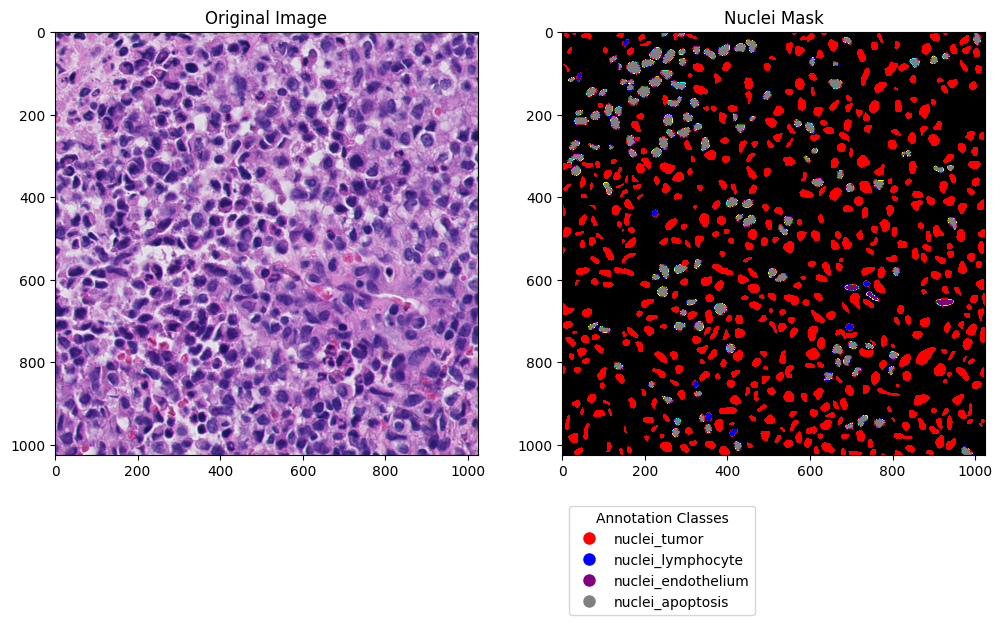

In [27]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from skimage.draw import polygon
from tifffile import imread
from pprint import pprint

# Create a mask
if img.ndim == 3:
    height, width, _ = img.shape
else:
    height, width = img.shape

mask = np.zeros((height, width), dtype=np.uint8)

for feat in features:
    props = feat.get('properties', {})
    geometry = feat.get('geometry', {})
    cls_id = get_nucleus_class_int(props)
    if geometry.get('type') == 'Polygon':
        coords = geometry['coordinates'][0]
        x_coords = [c[0] for c in coords]
        y_coords = [c[1] for c in coords]
        rr, cc = polygon(y_coords, x_coords, shape=(height, width))
        mask[rr, cc] = cls_id

# Check what classes are present in this mask
unique_ids = np.unique(mask)
print("Unique values in mask (class IDs):", unique_ids)

# Create a colormap and legend
# We will make a simple colormap where each class ID has a distinct color.
# For simplicity, let's use a predefined colormap and pick colors for each class.
from matplotlib.colors import ListedColormap

# Assign a distinct color to each class. For more aesthetics, choose any colors you like.
# Index 0 is background, so let's start from a neutral color for background.
colors = [
    '#000000',  # 0: background (black)
    '#ff0000',  # 1: nuclei_tumor (red)
    '#0000ff',  # 2: nuclei_lymphocyte (blue)
    '#ff00ff',  # 3: nuclei_plasma_cell (magenta)
    '#ffa500',  # 4: nuclei_histiocyte (orange)
    '#008000',  # 5: nuclei_melanophage (green)
    '#00ffff',  # 6: nuclei_neutrophil (cyan)
    '#ffff00',  # 7: nuclei_stroma (yellow)
    '#800080',  # 8: nuclei_endothelium (purple)
    '#a52a2a',  # 9: nuclei_epithelium (brown)
    '#808080'   # 10: nuclei_apoptosis (gray)
]

# Task 1
colors_task1 = [
    '#000000',  # 0: background (black)
    '#ff0000',  # 1: nuclei_tumor (red)
    '#0000ff',  # 2: nuclei_lymphocyte + nuclei_plasma_cell (blue)
    '#008000',  # 3: other (green)
]

# Since we have 11 indices (0 to 10), we can directly slice the list if fewer classes appear.
max_class_id = max(class_map.values())
cmap = ListedColormap(colors[:max_class_id+1])

# Plot the image and mask
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.set_title("Original Image")
# Show first channel if RGBA
if img.ndim == 3 and img.shape[2] == 4:
    ax1.imshow(img[..., :3])  # Just drop the alpha channel
else:
    ax1.imshow(img, cmap='gray')

ax2.set_title("Nuclei Mask")
# Set vmin and vmax so it uses the full colormap range
im = ax2.imshow(mask, cmap=cmap, vmin=0, vmax=max_class_id)

# Create a legend:
# We'll only display classes actually present in unique_ids (besides 0)
present_classes = [cid for cid in unique_ids if cid in class_map.values()]
# Reverse the class_map to get name from id
inv_class_map = {v:k for k,v in class_map.items()}
legend_elements = []
for cid in present_classes:
    # Add a patch with the corresponding color
    color = colors[cid]
    class_name = inv_class_map.get(cid, 'unknown')
    legend_elements.append(
        plt.Line2D([0], [0], marker='o', color='w', label=class_name,
                   markerfacecolor=color, markersize=10)
    )
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0, -0.25), title='Annotation Classes')
#ax2.legend(handles=legend_elements, loc='upper right')
plt.show()

In [28]:
# ================================================
# Batch Processing & Setup
# ================================================

import os
import glob
import json
import numpy as np
from tifffile import imread
from shapely.geometry import Polygon
from skimage.draw import polygon
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

# ------- Create a function to generate masks -------
def create_nuclei_mask(image_path, annotation_path):
    with open(annotation_path, 'r') as f:
        annotation_data = json.load(f)
    features = annotation_data['features']

    img = imread(image_path)
    if img.ndim == 3:
        height, width, _ = img.shape
    else:
        height, width = img.shape

    mask = np.zeros((height, width), dtype=np.uint8)
    for feat in features:
        props = feat.get('properties', {})
        geometry = feat.get('geometry', {})
        cls_id = get_nucleus_class_int_task1(props) # changed to task1
        if geometry.get('type') == 'Polygon':
            coords = geometry['coordinates'][0]
            x_coords = [c[0] for c in coords]
            y_coords = [c[1] for c in coords]
            rr, cc = polygon(y_coords, x_coords, shape=(height, width))
            mask[rr, cc] = cls_id

    return img, mask

# ------- Batch Process All Training Data -------
annotation_files = glob.glob('./data/nuclei_annotations/01_training_dataset_geojson_nuclei/*.geojson')
output_image_dir = './data/processed_images'
output_mask_dir = './data/processed_masks'
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

In [29]:
for ann_file in annotation_files:
    base_name = os.path.basename(ann_file).replace('_nuclei.geojson', '')
    # Find matching image
    img_files = glob.glob(f'./data/ROIs/01_training_dataset_tif_ROIs/{base_name}.tif')
    if len(img_files) != 1:
        continue
    img_path = img_files[0]
    img, mask = create_nuclei_mask(img_path, ann_file)

    # Save npy files for convenience
    np.save(os.path.join(output_image_dir, base_name+'.npy'), img)
    np.save(os.path.join(output_mask_dir, base_name+'_mask.npy'), mask)

# At this point, I have .npy files for images and masks of all ROIs.

In [30]:
# Analyze class distributions
import os
import numpy as np

def compute_class_weights(mask_folder):
    class_pixel_counts = {}
    for mask_file in os.listdir(mask_folder):
        mask_path = os.path.join(mask_folder, mask_file)
        mask = np.load(mask_path)
        unique, counts = np.unique(mask, return_counts=True)
        for cls, count in zip(unique, counts):
            class_pixel_counts[cls] = class_pixel_counts.get(cls, 0) + count
    return class_pixel_counts

mask_folder = '/home/censky2/MLDLFinal/data/processed_masks'
class_weights = compute_class_weights(mask_folder)
perc = {}
total = sum(class_weights.values()) + 0.0

for k, v in class_weights.items():
    perc[k] = class_weights[k] / total

# Prints class name, class count, class percentage
print("Class Pixel Counts:")
for k, v in class_weights.items():
    print({i for i in class_map_task1 if class_map_task1[i] == k}, v, perc[k])

Class Pixel Counts:
set() 163527701 0.7607422851934665
{'nuclei_tumor'} 35889074 0.1669584786019674
{'other'} 8241135 0.03833833554895913
{'til'} 7300170 0.0339609006556069


In [31]:
# Split data into train/val/test
import shutil

generator = torch.Generator().manual_seed(42)
files = sorted(glob.glob(os.path.join(output_image_dir, '*.npy')))
train_size = int(0.7 * len(files))
val_size = int(0.2 * len(files))
test_size = len(files) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(range(len(files)), [train_size, val_size, test_size], generator=generator)

# Copy train
if not os.path.exists('./data/processed_images_train/') and not os.path.exists('./data/processed_masks_train/'):
    os.makedirs('./data/processed_images_train/')
    os.makedirs('./data/processed_masks_train/')
    for i in range(len(train_dataset)):
        original_file_path = files[train_dataset[i]]
        file_name = os.path.basename(original_file_path)
        destination_file_path = os.path.join('./data/processed_images_train/', file_name)
        shutil.copy(original_file_path, destination_file_path)

        base_name = os.path.splitext(os.path.basename(file_name))[0]
        mask_file = os.path.join(output_mask_dir, base_name+'_mask.npy')
        file_name = os.path.basename(mask_file)
        destination_file_path = os.path.join('./data/processed_masks_train/', file_name)
        shutil.copy(mask_file, destination_file_path)

# Copy val
if not os.path.exists('./data/processed_images_val/') and not os.path.exists('./data/processed_masks_val/'):
    os.makedirs('./data/processed_images_val/')
    os.makedirs('./data/processed_masks_val/')
    for i in range(len(val_dataset)):
        original_file_path = files[val_dataset[i]]
        file_name = os.path.basename(original_file_path)
        destination_file_path = os.path.join('./data/processed_images_val/', file_name)
        shutil.copy(original_file_path, destination_file_path)

        base_name = os.path.splitext(os.path.basename(file_name))[0]
        mask_file = os.path.join(output_mask_dir, base_name+'_mask.npy')
        file_name = os.path.basename(mask_file)
        destination_file_path = os.path.join('./data/processed_masks_val/', file_name)
        shutil.copy(mask_file, destination_file_path)

# Copy test
if not os.path.exists('./data/processed_images_test/') and not os.path.exists('./data/processed_masks_test/'):
    os.makedirs('./data/processed_images_test/')
    os.makedirs('./data/processed_masks_test/')
    for i in range(len(test_dataset)):
        original_file_path = files[test_dataset[i]]
        file_name = os.path.basename(original_file_path)
        destination_file_path = os.path.join('./data/processed_images_test/', file_name)
        shutil.copy(original_file_path, destination_file_path)

        base_name = os.path.splitext(os.path.basename(file_name))[0]
        mask_file = os.path.join(output_mask_dir, base_name+'_mask.npy')
        file_name = os.path.basename(mask_file)
        destination_file_path = os.path.join('./data/processed_masks_test/', file_name)
        shutil.copy(mask_file, destination_file_path)


In [32]:
# ------- Create a PyTorch Dataset for Training -------
class NucleiDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, num_samples=5):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_files = sorted(glob.glob(os.path.join(img_dir, '*.npy')))
        self.num_samples = num_samples

        for file in self.img_files:
            base_name = os.path.splitext(os.path.basename(file))[0]
            mask_file = os.path.join(self.mask_dir, base_name+'_mask.npy')
            mask = np.load(mask_file)
            unique, counts = np.unique(mask, return_counts=True)
            if len(counts) == 4 and counts[2] + counts[3] > counts[1]:
                self.img_files = self.img_files + self.num_samples * [file]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        base_name = os.path.splitext(os.path.basename(img_file))[0]
        mask_file = os.path.join(self.mask_dir, base_name+'_mask.npy')

        img = np.load(img_file)
        mask = np.load(mask_file)

        # If the image has RGBA, you can either use all channels or just RGB
        if img.ndim == 3 and img.shape[2] == 4:
            img = img[..., :3]
            
        # Optional transforms (normalization, augmentation) can be applied here
        # E.g., simple normalization:

        if self.transform != None:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']
        
        img = img / 255.0

        # Convert to tensors
        img_tensor = torch.from_numpy(img.transpose(2,0,1)).float()  # C,H,W
        mask_tensor = torch.from_numpy(mask).long()  # H,W


        return img_tensor, mask_tensor

In [33]:
# ------- Load the dataset -------
from albumentations import (
    HorizontalFlip, VerticalFlip, RandomRotate90,
    RandomBrightnessContrast, ShiftScaleRotate, 
    GaussNoise, ElasticTransform, 
    GridDistortion, OpticalDistortion,
    Blur, CLAHE, 
    Compose, OneOf
)

transforms = Compose([
    # Spatial transformations
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomRotate90(p=0.5),
    
    # Geometric transformations
    ShiftScaleRotate(
        shift_limit=0.05, 
        scale_limit=0.1, 
        rotate_limit=20, 
        p=0.7
    ),
    
    # Color/intensity transformations
    OneOf([
        RandomBrightnessContrast(
            brightness_limit=0.1, 
            contrast_limit=0.1, 
            p=0.5
        ),
        CLAHE(clip_limit=2, p=0.3),
    ], p=0.5),
    
    # Noise and distortion
    OneOf([
        GaussNoise(var_limit=(0.01, 0.05), p=0.3),
        Blur(blur_limit=3, p=0.2),
    ], p=0.3),
    
    # Advanced geometric distortions
    OneOf([
        ElasticTransform(
            alpha=120, 
            sigma=120 * 0.05, 
            alpha_affine=120 * 0.03, 
            p=0.3
        ),
        GridDistortion(p=0.3),
        OpticalDistortion(distort_limit=0.1, shift_limit=0.1, p=0.3)
    ], p=0.3)
])
# transforms = None

train_dataset = NucleiDataset('./data/processed_images_train', './data/processed_masks_train', transform=transforms, num_samples=4)
val_dataset = NucleiDataset('./data/processed_images_val', './data/processed_masks_val', transform=None, num_samples=0)
test_dataset = NucleiDataset('./data/processed_images_test', './data/processed_masks_test', transform=None, num_samples=0)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

/tmp/ipykernel_1178068/2900986193.py:43: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  ElasticTransform(


In [ ]:
# Custom loss function: combine cross entropy loss and dice loss
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp

class CombinedLoss(nn.Module):
    def __init__(self, num_classes, weight=None, alpha=0):
        super(CombinedLoss, self).__init__()
        self.num_classes = num_classes
        self.ce_loss = nn.CrossEntropyLoss(weight=weight)
        self.dice_loss = smp.losses.DiceLoss('multiclass', smooth=0.01, ignore_index=0)
        self.alpha = alpha

    def forward(self, outputs, targets):
        # CrossEntropyLoss
        ce_loss = self.ce_loss(outputs, targets)

        # DiceLoss
        dice_loss = self.dice_loss(outputs, targets)

        # ComboLoss
        combined_loss = self.alpha * ce_loss + (1 - self.alpha) * dice_loss
        return combined_loss

In [ ]:

# # ------- Model Definition (Example: A Simple UNet) -------
# # For now, we'll use a simple UNet from a common PyTorch repo.
# # install a model or implement our own by the requirement of proposal later (Hover net and F1 score).

# from segmentation_models_pytorch import Unet

# # A simple UNet for 11 classes (0 background + 10 nuclei classes)
# model = Unet(encoder_name='resnet34', in_channels=3, classes=11).cuda()

# # ------- Training Setup -------
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# # ------- Training Loop Example -------
# num_epochs = 10  # For demonstration, use more epochs in practice

# for epoch in range(num_epochs):
#     model.train()
#     for imgs, masks in train_loader:
#         imgs = imgs.cuda()
#         masks = masks.cuda()

#         optimizer.zero_grad()
#         outputs = model(imgs)
#         loss = criterion(outputs, masks)
#         loss.backward()
#         optimizer.step()

#     # Validation step
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for imgs, masks in val_loader:
#             imgs = imgs.cuda()
#             masks = masks.cuda()
#             outputs = model(imgs)
#             loss = criterion(outputs, masks)
#             val_loss += loss.item()
#     val_loss /= len(val_loader)
#     print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}")

# # After training, refine model, possibly improve data augmentation,
# # tune hyperparameters, and eventually use the baseline repo and Docker
# # instructions from the challenge to prepare your final submission.


import os, torch
os.chdir('/home/censky2/MLDLFinal/hover_next_train-main/')
from src.multi_head_unet import get_model
os.chdir('/home/censky2/MLDLFinal/')
# ------- Model Definition (Example: HoverNext) -------
PATH = '/home/censky2/MLDLFinal/models/model14.pth'
num_classes = 4
model = get_model(out_channels_cls=num_classes, out_channels_inst=1).cuda()
# model = Unet(encoder_name='resnet34', in_channels=3, classes=4).cuda()

# ------- Training Setup -------
# Calculate weights of classes using previous distribution analysis for loss function
# class_percentages = []
# for k, v in perc.items():
#     class_percentages.append(v)

# class_weights = 1 / np.sqrt(np.array(class_percentages))
# normalized_weights = class_weights / class_weights.sum()
# weights_tensor = torch.tensor(normalized_weights, dtype=torch.float32).cuda()
weights_tensor = None

# criterion = torch.nn.CrossEntropyLoss(weight=weights_tensor)
# criterion = torch.nn.CrossEntropyLoss()
criterion = CombinedLoss(num_classes=num_classes, weight=weights_tensor, alpha=0.5)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.001)

# ------- Training Loop Example -------
num_epochs = 200  # For demonstration, use more epochs in practice
patience = 5
epochs_no_improve = 0
min_val_loss = np.inf
min_val_loss_epoch = 0

train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for imgs, masks in train_loader:
        imgs = imgs.cuda()
        masks = masks.cuda()
        optimizer.zero_grad()
        outputs = model(imgs)
        class_channels = outputs[:, :num_classes, :, :]
        loss = criterion(class_channels, masks)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.cuda()
            masks = masks.cuda()
            outputs = model(imgs)
            class_channels = outputs[:, :num_classes, :, :]
            loss = criterion(class_channels, masks)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        min_val_loss_epoch = epoch + 1
        epochs_no_improve = 0  # Reset the counter if there's improvement
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH)
    else:
        epochs_no_improve += 1

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    # if epochs_no_improve >= patience:
    #     print(f"Early stopping triggered at epoch {epoch+1}")
    #     break

# After training, refine model, possibly improve data augmentation,
# tune hyperparameters, and eventually use the baseline repo and Docker
# instructions from the challenge to prepare your final submission.

print(f"Epoch {min_val_loss_epoch}, Minimum Validation Loss: {min_val_loss}")


Epoch 1/200, Train Loss: 0.7943362470935372, Validation Loss: 0.6216155602818444
Epoch 2/200, Train Loss: 0.5934054860297371, Validation Loss: 0.4783548443090348
Epoch 3/200, Train Loss: 0.4926297736956793, Validation Loss: 0.41714834031604586
Epoch 4/200, Train Loss: 0.45957988719729814, Validation Loss: 0.39106487944012597
Epoch 5/200, Train Loss: 0.4173139309620156, Validation Loss: 0.34589430122148423
Epoch 6/200, Train Loss: 0.3936970735735753, Validation Loss: 0.33769815947328297
Epoch 7/200, Train Loss: 0.3782494803342749, Validation Loss: 0.3490050122851417
Epoch 8/200, Train Loss: 0.37154059123028726, Validation Loss: 0.33602458522433326
Epoch 9/200, Train Loss: 0.3742904486682485, Validation Loss: 0.32724416114035104
Epoch 10/200, Train Loss: 0.35340056075331044, Validation Loss: 0.3156145293088186
Epoch 11/200, Train Loss: 0.3361360551241566, Validation Loss: 0.3009870910928363
Epoch 12/200, Train Loss: 0.32230747567818446, Validation Loss: 0.31034939274901435
Epoch 13/200, 

KeyboardInterrupt: 

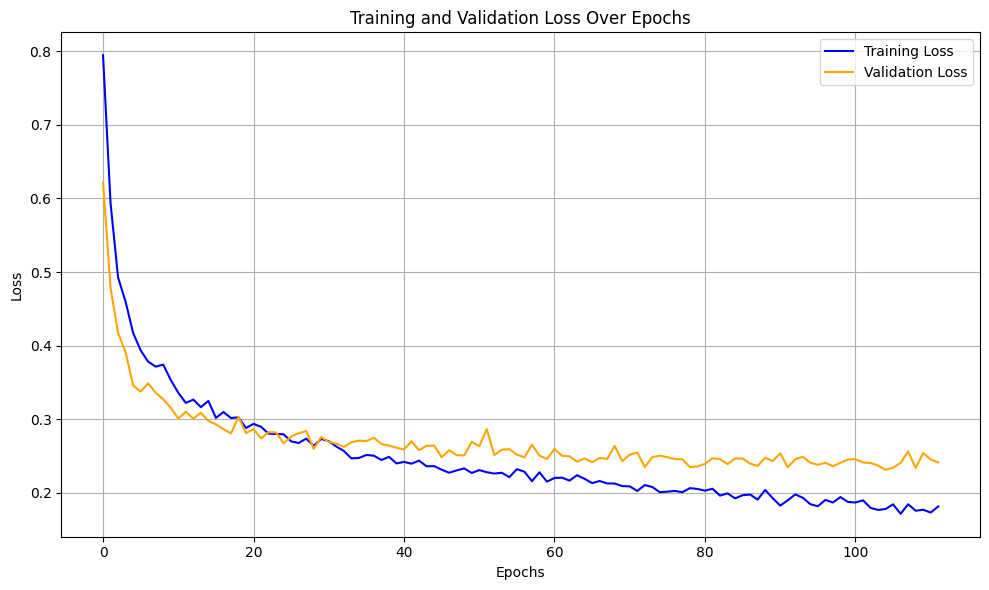

In [ ]:
# Plot train and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [34]:
num_batches = len(train_loader)
print("Number of batches in the training set:", num_batches)

Number of batches in the training set: 136


In [35]:
total_samples = len(train_dataset)
print("Total number of samples in the training dataset:", total_samples)


Total number of samples in the training dataset: 271


Pick a sample from the validation set. \
Run the model’s prediction on it (inference). \
Convert the output logits to class predictions (using argmax). \
Visualize the image, the ground truth mask, and the predicted mask side by side. \
add a legend to understand which class each color corresponds to.

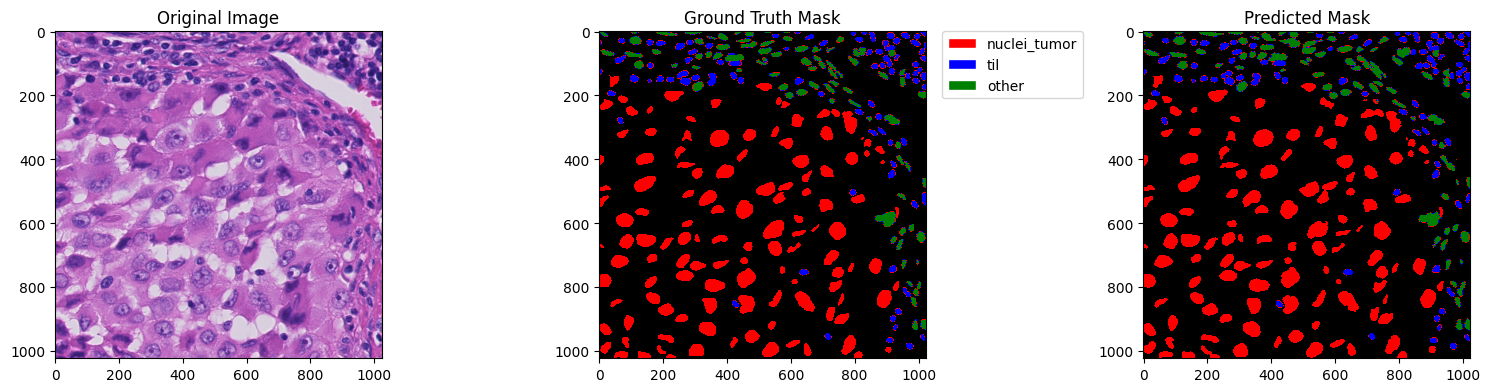

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Ensure the model is in evaluation mode
model.eval()

# Get one batch from the validation loader
val_iter = iter(val_loader)
imgs, masks = next(val_iter)

imgs = imgs.cuda()
with torch.no_grad():
    outputs = model(imgs)
    class_channels = outputs[:, :num_classes, :, :]
    

# outputs shape is (batch_size, num_classes, height, width)
# We need to get the predicted class for each pixel.
preds = torch.argmax(class_channels, dim=1)  # shape: (batch_size, height, width)

imgs = imgs.cpu().numpy()  # convert back to CPU and numpy
masks = masks.cpu().numpy()
preds = preds.cpu().numpy()

# Let’s pick a random sample from this batch to visualize
idx = np.random.randint(0, imgs.shape[0])

img_sample = imgs[idx]       # shape: (C, H, W)
mask_sample = masks[idx]     # shape: (H, W)
pred_sample = preds[idx]     # shape: (H, W)

# If the image has 3 channels (RGB), transpose it back to HWC for plotting
img_sample = img_sample.transpose(1, 2, 0)  # H, W, C

# Normalize image for display if needed (if already normalized, might be fine)
# If we divided by 255 previously, the image should be in [0, 1]
# If it looks too dark, you can skip or adjust normalization.

# class_map = {
#     1: 'nuclei_tumor',
#     2: 'nuclei_lymphocyte',
#     3: 'nuclei_plasma_cell',
#     4: 'nuclei_histiocyte',
#     5: 'nuclei_melanophage',
#     6: 'nuclei_neutrophil',
#     7: 'nuclei_stroma',
#     8: 'nuclei_endothelium',
#     9: 'nuclei_epithelium',
#     10: 'nuclei_apoptosis'
# }
# colors = [
#     '#000000',  # 0: background
#     '#ff0000',  # 1: nuclei_tumor (red)
#     '#0000ff',  # 2: nuclei_lymphocyte (blue)
#     '#ff00ff',  # 3: nuclei_plasma_cell (magenta)
#     '#ffa500',  # 4: nuclei_histiocyte (orange)
#     '#008000',  # 5: nuclei_melanophage (green)
#     '#00ffff',  # 6: nuclei_neutrophil (cyan)
#     '#ffff00',  # 7: nuclei_stroma (yellow)
#     '#800080',  # 8: nuclei_endothelium (purple)
#     '#a52a2a',  # 9: nuclei_epithelium (brown)
#     '#808080'   # 10: nuclei_apoptosis (gray)
# ]

max_class_id = max(class_map_task1.values())
cmap = ListedColormap(colors_task1[:max_class_id+1])

# Create legend elements
from matplotlib.patches import Patch
legend_elements = []
for class_name, class_id in class_map_task1.items():
    legend_elements.append(
        Patch(facecolor=colors_task1[class_id], edgecolor='w', label=class_name)
    )

# Plot the original image, ground truth mask, and predicted mask
fig, axes = plt.subplots(1, 3, figsize=(15,5))

axes[0].set_title("Original Image")
# If image is RGBA, display only RGB
if img_sample.shape[2] == 4:
    axes[0].imshow(img_sample[..., :3])
else:
    axes[0].imshow(img_sample)

axes[1].set_title("Ground Truth Mask")
im = axes[1].imshow(mask_sample, cmap=cmap, vmin=0, vmax=max_class_id)
axes[1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

axes[2].set_title("Predicted Mask")
axes[2].imshow(pred_sample, cmap=cmap, vmin=0, vmax=max_class_id)

plt.tight_layout()
plt.show()



Created a mask with shape: (1024, 1024)
Unique values in mask (class IDs): [ 0  1  2  8 10]


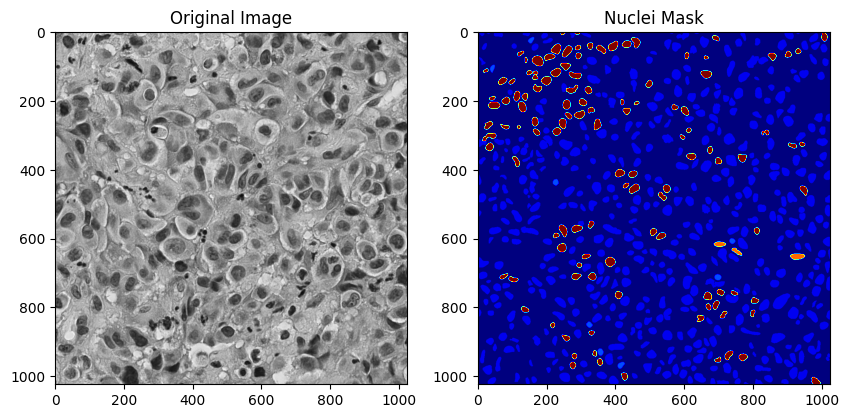

In [ ]:

# Step 8: If we have the image loaded, create a mask for the entire ROI.
# The mask should have the same height and width as the image.
# Each nucleus polygon will be rasterized onto this mask with a unique class ID.

if img is not None:
    if img.ndim == 3:
        height, width, _ = img.shape
    else:
        height, width = img.shape

    mask = np.zeros((height, width), dtype=np.uint8)

    # Iterate over each nucleus feature
    for feat in features:
        props = feat.get('properties', {})
        geometry = feat.get('geometry', {})

        # Get class ID for this nucleus
        cls_id = get_nucleus_class_int(props)

        # Only proceed if geometry is a Polygon
        if geometry.get('type') == 'Polygon':
            # Coordinates are usually stored as [ [ [x1, y1], [x2, y2], ... ] ]
            coords = geometry['coordinates'][0]
            x_coords = [c[0] for c in coords]
            y_coords = [c[1] for c in coords]

            # Convert polygon coordinates into row and column indices
            # polygon(...) expects row=y and col=x
            rr, cc = polygon(y_coords, x_coords, shape=(height, width))
            mask[rr, cc] = cls_id

    print("\nCreated a mask with shape:", mask.shape)
    print("Unique values in mask (class IDs):", np.unique(mask))

    # display the mask next to the image
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(img if img.ndim == 2 else img[...,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.title("Nuclei Mask")
    plt.imshow(mask, cmap='jet')
    plt.show()
else:
    print("No image to create a mask for. Make sure your image_path is correct and matches the geojson file name.")


Above is try to map the different nuclei for single image in training set. \
Prints the number of nuclei features in the loaded .geojson file. \
Prints the structure of one feature to understand how annotations are stored. \
Shows properties and geometry of that feature. \
Finds the corresponding .tif image using a filename pattern. \
Loads the image and prints its shape. \
Defines a class mapping function to assign numeric class IDs to each nucleus type. \
Creates a mask from the polygon annotations, where each pixel inside a nucleus polygon is given the nucleus’s class ID. \
Displays the image and mask using matplotlib to visualize the result.

In [16]:
# Load Model
import os, torch
os.chdir('/home/censky2/MLDLFinal/hover_next_train-main/')
from src.multi_head_unet import get_model
os.chdir('/home/censky2/MLDLFinal/')
PATH = '/home/censky2/MLDLFinal/models/model10.pth'
num_classes = 4

model = get_model(out_channels_cls=num_classes, out_channels_inst=1).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

checkpoint = torch.load(PATH, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
# Create JSON files for evaluation
import torch
import numpy as np
import json
import os
import cv2
from scipy.ndimage import label
import shutil

# Adapted from supervision library
def mask_to_polygons(mask: np.ndarray, num_classes: int):
    """
    Converts a binary mask to a list of polygons.

    Parameters:
        mask (np.ndarray): A binary mask represented as a 2D NumPy array of
            shape `(H, W)`, where H and W are the height and width of
            the mask, respectively.

    Returns:
        List[np.ndarray]: A list of polygons, where each polygon is represented by a
            NumPy array of shape `(N, 2)`, containing the `x`, `y` coordinates
            of the points. Polygons with fewer points than `MIN_POLYGON_POINT_COUNT = 3`
            are excluded from the output.
    """
    class_polygons = {}

    for cls in range(num_classes):
        # Create binary mask for the current class
        binary_mask = (mask == cls).astype(np.uint8)

        # Find contours for the binary mask
        contours, _ = cv2.findContours(
            binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
        )

        # Extract valid polygons (with at least 3 points)
        polygons = [
            np.squeeze(contour, axis=1)
            for contour in contours
            if contour.shape[0] >= 3
        ]

        # Store polygons for the current class
        class_polygons[cls] = polygons

    return class_polygons


def generate_json_from_model(model, test_loader, num_classes, output_dir, output_dir_gt):
    model.eval()

    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    if os.path.exists(output_dir_gt):
        shutil.rmtree(output_dir_gt)

    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(output_dir_gt, exist_ok=True)

    with torch.no_grad():
        for batch_idx, (imgs, masks) in enumerate(test_loader):
            imgs = imgs.cuda()
            masks = masks.cuda()
            outputs = model(imgs)
            class_channels = outputs[:, :num_classes, :, :]

            for i in range(class_channels.shape[0]):
                class_channel = class_channels[i, :, : ,:]
                mask_class_channel = masks[i, :, :]
                predictions = torch.argmax(class_channel, dim=0)
                polygon = mask_to_polygons(predictions.cpu().numpy(), num_classes=num_classes)
                polygon_gt = mask_to_polygons(mask_class_channel.cpu().numpy(), num_classes=num_classes)

                json_data = {
                    "type": "Multiple polygons",
                    "polygons": []
                }

                json_data_gt = {
                    "type": "Multiple polygons",
                    "polygons": []
                }


                # Add polygons for each class
                for cls, polygons in polygon.items():
                    if cls != 0:
                        for polygon in polygons:
                            seed_point = [float(polygon[0][0]), float(polygon[0][1]), 0.5]

                            # Convert polygon points to the required format (x, y, 0.5)
                            path_points = [[float(x), float(y), 0.5] for x, y in polygon]

                            # Construct the polygon data
                            polygon_data = {
                                "name": f"class_{cls}",  # Replace with actual class names if available
                                "seed_point": seed_point,
                                "path_points": path_points,
                                "sub_type": "",
                                "groups": [],
                                "probability": 1 
                            }

                            # Append the polygon data to the JSON structure
                            json_data["polygons"].append(polygon_data)
                
                # Add polygons for each class
                for cls, polygons in polygon_gt.items():
                    if cls != 0:
                        for polygon in polygons:
                            seed_point = [float(polygon[0][0]), float(polygon[0][1]), 0.5]

                            # Convert polygon points to the required format (x, y, 0.5)
                            path_points = [[float(x), float(y), 0.5] for x, y in polygon]

                            # Construct the polygon data
                            polygon_data = {
                                "name": f"class_{cls}",  # Replace with actual class names if available
                                "seed_point": seed_point,
                                "path_points": path_points,
                                "sub_type": "",
                                "groups": [],
                                "probability": 1
                            }

                            # Append the polygon data to the JSON structure
                            json_data_gt["polygons"].append(polygon_data)

                # Save JSON to file
                json_filename = os.path.join(output_dir, f"prediction_{batch_idx}_{i}.json")
                with open(json_filename, 'w') as json_file:
                    json.dump(json_data, json_file, indent=4)

                json_filename = os.path.join(output_dir_gt, f"gt_{batch_idx}_{i}.json")
                with open(json_filename, 'w') as json_file:
                    json.dump(json_data_gt, json_file, indent=4)

    print(f"JSON files saved in: {output_dir}")

output_dir = "/home/censky2/MLDLFinal/data/predictions_json"
output_dir_gt = "/home/censky2/MLDLFinal/data/predictions_gt_json"
generate_json_from_model(model, test_loader, num_classes, output_dir, output_dir_gt)

JSON files saved in: /home/censky2/MLDLFinal/data/predictions_json


In [24]:
# F1 score eval from baseline github
import os
import json
import numpy as np


def calculate_centroid(points):
    """
    Calculate the centroid of a polygon given its points.
    Points should be a list of [x, y] coordinates.
    """
    points = np.array(points)
    centroid = np.mean(points, axis=0)
    return centroid


def extract_features_from_json(json_data, json_name):
    features_list = []
    for polygon_data in json_data.get('polygons', []):
        category = polygon_data['name']
        score = polygon_data.get('score', 1)
        path_points = polygon_data['path_points']

        if len(path_points) < 3:
            continue  # A valid polygon needs at least 3 points

        exterior_coords = [coord[:2] for coord in path_points]
        centroid = calculate_centroid(exterior_coords)

        features_list.append({
            'filename': json_name,
            'category': category,
            'centroid': centroid.tolist(),
            'score': score
        })
    return features_list


def process_json_file(json_file_path):
    json_name = os.path.basename(json_file_path)
    with open(json_file_path, 'r') as f:
        json_data = json.load(f)
        features = extract_features_from_json(json_data, json_name)

    return features


def calculate_centroid_distance(gt_features, pred_features):
    results = []
    pred_structure = {}

    # Organize pred_features into a dictionary (pred_structure) for faster access
    for pred_feature in pred_features:
        match_key = pred_feature['category']
        if match_key not in pred_structure:
            pred_structure[match_key] = []
        pred_structure[match_key].append(pred_feature)

    for gt_feature in gt_features:
        match_key = gt_feature['category']
        eligible_predictions = []

        # Check if there are predictions matching the same filename and category
        if match_key in pred_structure:
            for pred_feature in pred_structure[match_key]:
                # Calculate the Euclidean distance between ground truth and prediction centroids
                distance = np.linalg.norm(np.array(gt_feature['centroid']) - np.array(pred_feature['centroid']))

                # Filter predictions based on a distance threshold (e.g., 15 units)
                if distance < 15:
                    eligible_predictions.append({
                        'pred_json': pred_feature['filename'],
                        'gt_category': gt_feature['category'],
                        'pred_category': pred_feature['category'],
                        'distance': distance,
                        'pred_score': pred_feature['score'],
                        'pred_feature': pred_feature,
                    })

        # Sort eligible predictions by descending prediction score and ascending distance
        eligible_predictions.sort(key=lambda x: (-x['pred_score'], x['distance']))

        # If we have any eligible prediction, take the best match
        if eligible_predictions:
            best_match = eligible_predictions[0]
            results.append(best_match)

            # Find and remove the used prediction from pred_structure
            for i, pred in enumerate(pred_structure[match_key]):
                if np.array_equal(pred['centroid'], best_match['pred_feature']['centroid']):
                    del pred_structure[match_key][i]
                    break

    return results


def calculate_classification_metrics(results, gt_features, pred_features):
    # Extract true positive categories (matched predictions)
    pred_tp = [match['pred_category'] for match in results]

    # Ground truth categories
    ground_truth = [feature['category'] for feature in gt_features]

    # All predicted categories
    pred_all = [feature['category'] for feature in pred_features]

    # Count occurrences of each category in ground truth, predictions, and true positives
    gt_dict = dict(zip(*np.unique(ground_truth, return_counts=True)))
    pred_dict = dict(zip(*np.unique(pred_all, return_counts=True)))
    tp_dict = dict(zip(*np.unique(pred_tp, return_counts=True)))

    micro_TP, micro_FP, micro_FN = 0, 0, 0
    results_metrics = {}

    # Calculate metrics for each category
    for category in np.unique(list(gt_dict.keys()) + list(pred_dict.keys())):
        TP = tp_dict.get(category, 0)
        FP = pred_dict.get(category, 0) - TP
        FN = gt_dict.get(category, 0) - TP

        micro_TP += TP
        micro_FP += FP
        micro_FN += FN

        precision = TP / (TP + FP) if TP + FP > 0 else 0
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

        results_metrics[category] = {
            'TP': TP, 'FP': FP, 'FN': FN,
            'precision': precision, 'recall': recall, 'f1_score': f1_score
        }

    # Calculate micro metrics (aggregated across categories)
    micro_precision = micro_TP / (micro_TP + micro_FP) if micro_TP + micro_FP > 0 else 0
    micro_recall = micro_TP / (micro_TP + micro_FN) if micro_TP + micro_FN > 0 else 0
    micro_f1_score = 2 * micro_precision * micro_recall / (
                micro_precision + micro_recall) if micro_precision + micro_recall > 0 else 0

    # Calculate macro F1 (average of F1 scores per category)
    macro_f1_score = np.mean([metrics['f1_score'] for metrics in results_metrics.values()])

    results_metrics['micro'] = {
        'precision': micro_precision,
        'recall': micro_recall,
        'f1_score': micro_f1_score
    }
    results_metrics['macro'] = {
        'f1_score': macro_f1_score
    }

    return results_metrics


def evaluate_files(ground_truth_file, pred_file):
    gt_features = process_json_file(ground_truth_file)
    pred_features = process_json_file(pred_file)

    results = calculate_centroid_distance(gt_features, pred_features)
    metrics = calculate_classification_metrics(results, gt_features, pred_features)

    return metrics

# Average Macro F1
def evaluate_all_files(ground_truth_dir, pred_file_dir):
    overall_results = {}
    
    # Iterate through ground truth files
    for gt_filename in os.listdir(ground_truth_dir):
        # Ensure we're only processing JSON files
        if not gt_filename.endswith('.json'):
            continue
        
        pred_filename = "prediction" + gt_filename[2:]
        
        # Full paths to files
        gt_filepath = os.path.join(ground_truth_dir, gt_filename)
        pred_filepath = os.path.join(pred_file_dir, pred_filename)
        
        # Check if prediction file exists
        if not os.path.exists(pred_filepath):
            print(f"Warning: No prediction file found for {gt_filename}")
            continue
        
        try:
            # Evaluate this specific file pair
            file_metrics = evaluate_files(gt_filepath, pred_filepath)
            
            # Store results
            overall_results[gt_filename] = file_metrics
        
        except Exception as e:
            print(f"Error processing {gt_filename}: {e}")
    
    # Aggregate overall metrics if needed
    return overall_results

results = evaluate_all_files('/home/censky2/MLDLFinal/data/predictions_gt_json/', '/home/censky2/MLDLFinal/data/predictions_json/')

num_ex = 0
class_1_f1_sum = 0
class_2_f1_sum = 0
class_3_f1_sum = 0

for k1, v1 in results.items():
    for k2, v2 in v1.items():
        if k2 == 'class_1':
            class_1_f1_sum += v2['f1_score']
        elif k2 == 'class_2':
            class_2_f1_sum += v2['f1_score']
        elif k2 == 'class_3':
            class_3_f1_sum += v2['f1_score']
    num_ex += 1

if results:
        # Collect macro F1 scores
        macro_f1_scores = [file_metrics['macro']['f1_score'] for file_metrics in results.values()]
        print("\nOverall Summary:")
        print(f"Average Macro F1 Score: {sum(macro_f1_scores) / len(macro_f1_scores)}")
        print(f"Average F1 Score for Tumor Cells: {class_1_f1_sum / num_ex}")
        print(f"Average F1 Score for Lymphocytes and Plasma Cells: {class_2_f1_sum / num_ex}")
        print(f"Average F1 Score for Other Cells: {class_3_f1_sum / num_ex}")


Overall Summary:
Average Macro F1 Score: 0.828754878234327
Average F1 Score for Tumor Cells: 0.8484822124535304
Average F1 Score for Lymphocytes and Plasma Cells: 0.7586037080012759
Average F1 Score for Other Cells: 0.7524741545989485
